# Fitting Radio Lightcurves

**Lecturer:** Dougal Dobie<br>
**Jupyter Notebook Authors:** Dougal Dobie, David Kaplan

## Key steps
- Plot the radio light curve
- Determine its spectral index
- Scale the data based on its spectral index
- Fit the data with a power law
- Fit the data with a broken power law with a smooth turnover

## Required dependencies

* python 3
* astropy
* numpy
* scipy
* matplotlib
* emcee
* corner

# Introduction:
The radio properties of relativistic afterglows give a wealth of information on the properties of the explosion.  Back in the GRB days [REF] this was used to great effect.  We are now trying to use the same techniques on multi-messenger transients like binary neutron star mergers.  In particular, we will determine the basic time and spectral behavior of the radio lightcurve, which can be fit to determine the explosion energy, the surrounding circum-merger density, and other properties.

Here we will look at observations of GW170817 (published in Dobie et al. 2018 and Mooley et al. 2018, among others).  This consists of measurements of flux density $S_\nu(\nu,t)$ with several radio telescopes (Jansky Very Large Array, Australia Telescope Compact Array, and Giant Metrewave Radio Telescope) as a function of time since explosion (in days) and frequency (in GHz).  Flux density measurements are in units of $\mu\mathrm{Jy}$, where $1\,\mathrm{Jy}=10^{-26}\,\mathrm{erg/s/cm^2/Hz}$.


In [19]:
%matplotlib inline

In [11]:
# Preliminaries: load in python modules.  The uses of these will become clear as we go forward
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
import emcee
import corner
import os
from timeit import default_timer as timer

# Step 0: Load the data
We write a basic function to load in the radio lightcurve.  It's pretty easy using `astropy`.  But you should look at the file `radio_lightcurve.dat` and make sure that the data returned look appropriate.  It's also good to keep track of some basic info like:
1. How many observations are there?
2. What is the first observation date?  What is the last?
3. What is the lowest frequency?  What is the highest frequency?
4. Do all of the observations actually report _detections_, where the source is detected at $>3\sigma$ significance?

In [12]:
def load_data(filename='radio_lightcurve.dat'):
    data = ascii.read(filename)
    return data

data = load_data()

print(data)

delta_t telescope frequency flux rms 
------- --------- --------- ---- ----
  10.37       VLA       6.2  7.8  2.5
  16.42       VLA       3.0 18.7  6.3
  17.39       VLA       3.0 15.1  3.9
  18.33       VLA       3.0 14.5  3.7
  19.35       VLA       6.2 15.9  5.5
  21.36       VLA       6.2 13.6  2.9
  22.36       VLA       3.0 22.5  3.4
  23.36       VLA       6.0 22.6  3.4
  24.26       VLA       3.0 25.6  2.9
  31.32       VLA       3.0 34.0  3.6
    ...       ...       ...  ...  ...
 162.89       VLA      15.0 38.9  7.2
 162.89       VLA      17.0 43.5  7.7
 216.91       VLA       3.0 68.0 21.0
 216.88       VLA       6.0 39.0  9.0
 216.85       VLA      10.0 28.0  7.0
  216.8       VLA      15.0 21.0  5.0
 256.76       VLA       3.0 55.0 12.0
 272.67       VLA       3.0 44.0 11.0
 272.61       VLA       6.0 36.0  7.0
 288.61       VLA       3.0 46.0 11.0
 288.55       VLA       6.0 35.0  7.0
Length = 65 rows


You can inspect the data in two ways: `print(data.columns)` will print out the names of each column in the data table, and you can then examine the contents of each column using `print(data['column_name'])`.

You can also select subsets of the data using commands like `np.where(data['delta_t']>50` which will give the index of every row after 50 days.

In [13]:
print(data.columns)

data[np.where(data['delta_t'] < 100)]

<TableColumns names=('delta_t','telescope','frequency','flux','rms')>


delta_t,telescope,frequency,flux,rms
float64,str4,float64,float64,float64
10.37,VLA,6.2,7.8,2.5
16.42,VLA,3.0,18.7,6.3
17.39,VLA,3.0,15.1,3.9
18.33,VLA,3.0,14.5,3.7
19.35,VLA,6.2,15.9,5.5
21.36,VLA,6.2,13.6,2.9
22.36,VLA,3.0,22.5,3.4
23.36,VLA,6.0,22.6,3.4
24.26,VLA,3.0,25.6,2.9


# Step 1: Make a plot of the radio lightcurve
We will now plot the flux density as a function of time (the lightcurve). We use different coloured markers to denote the observing frequency, and different marker styles to denote different telescopes.

If you feel confident with Python, feel free to change edit the code below.

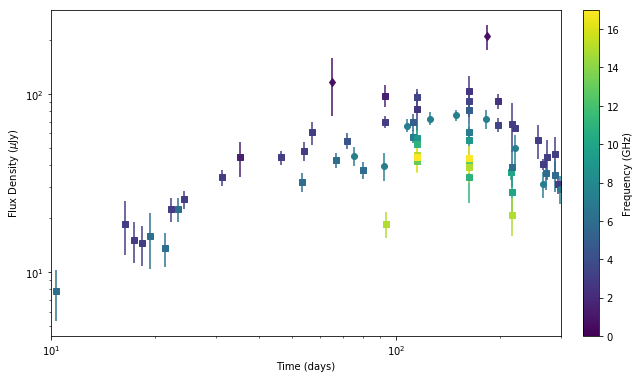

In [20]:
def plot_data(ax, sm, data, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        #Loop over each row of the data, set the marker colour based on frequency and the marker style based on telescope
        freq = row['frequency']
        colorval = sm.to_rgba(freq) #Set the marker colour based on observing frequency
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope] #Set the marker based on telescope
        
        #Are we plotting the original flux density values? Or the scaled values?
        if scaled:
            flux = row['scaled_flux']
            rms = row['scaled_rms']
        else:
            flux = row['flux']
            rms = row['rms']
        
        ax.errorbar(row['delta_t'], flux, rms, linestyle='', marker=marker, c=colorval, **kwargs) #Plot the flux density (with uncertainty) on the provided axis
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    '''
    This function will set up a scalar map for you to colour your markers by frequency
    '''
    freq_cmap = plt.cm.get_cmap(cmap)
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm    
    
def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    #Get the scalar map, plot the data using the plot_data function above
    sm = cmap_setup()
    plot_data(ax, sm, data, scaled=scaled)
    
    
    #Set up a colourbar
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    #Set axis scales to log
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #Label axes, set axis limits etc.
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')
        
    if model:
        plot_model(model, params, tvals, ax)
    
    if plot_models:
        plot_physical_models(ax)
    
    ax.set_xlim(10,300)
    
make_plot(data)

# Step 2: Determining the spectral index
As with many things in astrophysics, the emission in the radio regime is _non-thermal_ in origin (unlike the early emission in the optical/UV/infrared, which is a thermal blackbody).  What that means is that generally has a power-law spectrum:
$$ S_\nu(\nu) \propto \nu^\alpha$$
Strictly this only works for data observed at _exactly_ the same time, but real observations don't work that way.  A single telescope can (usually) only observe at a single frequency, and different telescopes are separated in time by schedules, longitude, etc.  So we need to be a bit more generous about how we define simultaneous. Luckily, the light-curve is mostly evolving pretty slowly, so this isn't necessarily a problem.

Here are two functions to take a subset of the data that was observed roughly simultaneously and calculate the spectral index $\alpha$ and its uncertainty using multi-band observation at 162 days post-merger.

In [15]:
def calc_power_law(freq,S0,alpha):
    S = S0 * (freq) ** alpha
    return S

def alpha_calc(data):    
    #Get lightcurve values
    freqs = data['frequency']
    flux = data['flux']
    flux_errs = data['rms']
    
    #Use the scipy curve_fit algorithm to calculate the best fit value
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1] #Best-fit spectral index
    alpha_err = np.sqrt(np.diag(pcov))[1] #Uncertainty in alpha
    
    return alpha, alpha_err

In [16]:
#Select the data at the ~162 day epoch and print the spectral index + uncertainty

sel_data = data[data['delta_t'] == 162.89]

alpha, alpha_err = alpha_calc(sel_data)

print("alpha = %.1f+/-%.1f"%(alpha, alpha_err))

alpha = -0.6+/-0.1


Questions:
1. What do you get for $\alpha$ and its uncertainty?
2. Do you think using a finite time window introduced significant errors into this calculation?
3. What happens if you use a larger time range?

## Step 3: Scaling the data based on the spectral Index
Based on the $\alpha$ you calculated above, what happens if you assume that _all_ of the observations can be fit using the same frequency power-law?  i.e., if $\alpha$ were the same at all times?  If this is the case then scaling all of the data to a single frequency makes it easier to understand the temporal properties of the lightcurve as a function of only 1 variable, not 2.

Write a function to take the observed data and scale it to a specific frequency based on an estimated spectral index. 

Don't forget to include uncertainties! You should add two columns to your data table called "scaled_flux" and "scaled_rms".

Questions:
1. Can you think of reasons why the spectral index should stay the same?  Why it should change?

In [17]:
def scale_data(data, alpha, alpha_err, ref_freq=5.0):
    #calculate a scaling factor for the flux density and uncertainty
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    #scale the flux and uncertainty - don't forget to add errors in quadrature
    scaled_flux = data['flux'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['flux'])**2 + (rms_scale/f_scale)**2)
    
    #Add two new columns to the data
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms
    
    return data

Scale the data to 3 GHz based on your estimated spectral index and associated uncertainty, then plot the scaled lightcurve by passing `scaled=True` to your `make_plot` function

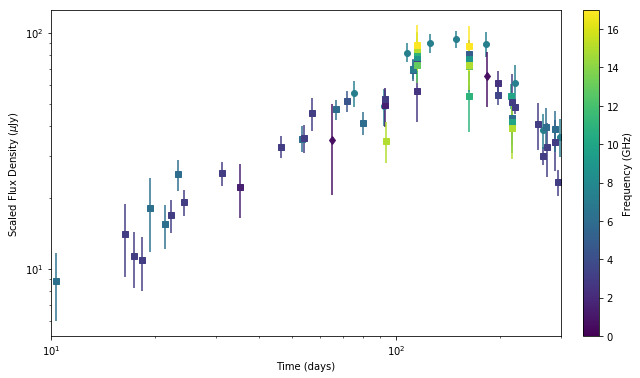

In [21]:
data = scale_data(data, alpha, alpha_err)
make_plot(data, scaled=True)

# Step 4: Fitting the data
We now want to characterise the radio lightcurve. You should be able to see that it initially rises according to a power law, peaks somewhere between 100 and 200 days post-merger and then declines according to a different power law.

Create a new table called tdata that we will use to determine the properties of the lightcurve

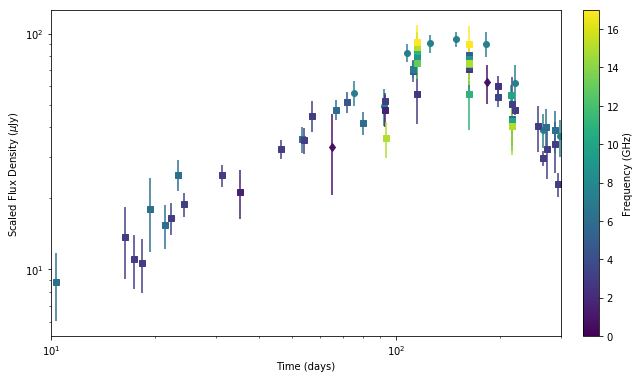

In [22]:
data = load_data()
tdata = scale_data(data, -0.6,0.05)

make_plot(tdata, scaled=True)

In [10]:
for i in tdata:
    print(i)

delta_t telescope frequency flux rms  scaled_flux    scaled_rms 
------- --------- --------- ---- --- ------------- -------------
  10.37       VLA       6.2  7.8 2.5 12.0574886993 3.88928179364
delta_t telescope frequency flux rms scaled_flux scaled_rms
------- --------- --------- ---- --- ----------- ----------
  16.42       VLA       3.0 18.7 6.3        18.7        6.3
delta_t telescope frequency flux rms scaled_flux scaled_rms
------- --------- --------- ---- --- ----------- ----------
  17.39       VLA       3.0 15.1 3.9        15.1        3.9
delta_t telescope frequency flux rms scaled_flux scaled_rms
------- --------- --------- ---- --- ----------- ----------
  18.33       VLA       3.0 14.5 3.7        14.5        3.7
delta_t telescope frequency flux rms  scaled_flux   scaled_rms 
------- --------- --------- ---- --- ------------- ------------
  19.35       VLA       6.2 15.9 5.5 24.5787269639 8.5487532487
delta_t telescope frequency flux rms  scaled_flux   scaled_rms 
------- -

We can fit this data with a "smoothed broken power law", which combines two power laws with a smoothing parameter around the break point. One functional form of this is given by

$S_\nu(t) = S_{\rm \nu,peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Here the spectral index is still $\alpha$, but we've also introduced _temporal_ power-law indices $\delta_1$ (before the break) and $\delta_2$ (after the break).  $S_{\rm \nu,peak}$ is the flux density at peak, and $s$ controls the smoothness of the break.

Write a function smooth_broken_power_law() that outputs a smoothed broken power law that also scales based on frequency and spectral index

*Hint: in python you can calculate $x^y$ using `x**y`*

In [23]:
def smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s, nu0=3.0):
    s = 10**log_s

    return (nu/nu0)**alpha * F_peak * ((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1.0/s)

## Using a Markov Chain Monte Carlo

We now want to fit a smoothed broken power law to our data. In our paper we do this via a parameter grid-search to minimise the goodness-of-fit parameter $\chi^2$, i.e., compute $\chi^2(S_{\nu,\rm peak},t_{\rm peak},\delta_1,\delta_2,\alpha,s)$ for a 6-dimension parameter grid. However, grid searches are slow and innefficient.  It's better to concentrate your effort in the part of the fit where the data "prefer" to go.  We can do this using a slightly more complicated statistical technique

Here we will perform an Markov Chain Monte Carlo (MCMC) fit using the [`emcee`](http://dfm.io/emcee/current/) package, to determine lightcurve parameters and the spectral index of the source. First you will need to write 3 functions that define your Probability, Prior and Likelihood.

We will use a uniform prior with $\delta_1>0$ (since we require the lightcurve to initially rise), $0<t_{\rm peak}<300$ (since our data only covers the period up to 200 days) and $s<100$. The parameters will be passed to the function via a tuple.

In [24]:
def lnprior(theta):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    if 0.0 < t_peak < 300.0 and delta_1 > 0.0 and log_s < 3:
        return 0.0
    
    else:
        return -np.inf

We will now write a likelihood function that takes the lightcurve parameters inside the tuple `theta`, along with the observed data.

In [25]:
def lnlike(theta, t, nu, S, S_err):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    model = smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s)
    inv_sigma2 = 1.0/S_err**2

    return -0.5*(np.sum((S-model)**2*inv_sigma2 - np.log(inv_sigma2)))

We then use a function to calculate the marginal probability using the `lnlike()` and `lnprior()` functions from above

In [26]:
def lnprob(theta, t, nu, S, S_err):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, t, nu, S, S_err)

We will now fit the data using the `emcee` package. The function `get_starting_pos()` provided below will set up an array of walker starting positions for given lightcurve parameters. Examine the lightcurve and estimate some reasonable values for these parameters and add them to the function.

In [27]:
def get_starting_pos(nwalkers, ndim=6):
    S_peak = 110
    t_peak = 150
    delta_1 = 0.8
    delta_2 = -2
    alpha = -0.6
    log_s = 1
    
    pos = [np.asarray([S_peak, t_peak, delta_1, delta_2, alpha, log_s]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

We write a function called `run_mcmc()` that will load the observed data, take the starting position and then run the emcee Ensemple Sampler. Use a small number of iterations and walkers initially (100/20) to see how long the code takes to run on your laptop. Then increase both parameters to a larger number so that the algorithm takes ~90 seconds to run.

In [28]:
def run_mcmc(data, niters=1000, nthreads=1, nwalkers=200, ndim=6):
    t = data['delta_t']
    nu = data['frequency']
    S = data['flux']
    S_err = data['rms']
    
    pos = get_starting_pos(nwalkers, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, nu, S, S_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler

We now want to inspect our chain to see if our algorithm has converged to a reasonable solution. We extract the chain from the sampler and then write a function to make a figure showing how each walker moves around the parameter space. The figure has 6 subplots (1 for each dimension), iteration number on the x-axis and parameter value on the y-axis.

MCMC algorithms typically use a burn-in phase, where the sampler is moving towards the optimum solution and not yet accurately sampling the parameter space. Add a parameter chain_cut to your function that plots a vertical line at the end of the burn-in.

In [29]:
sampler = run_mcmc(tdata)
chain = sampler.chain

/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in power


Computation time: 151.751245 s


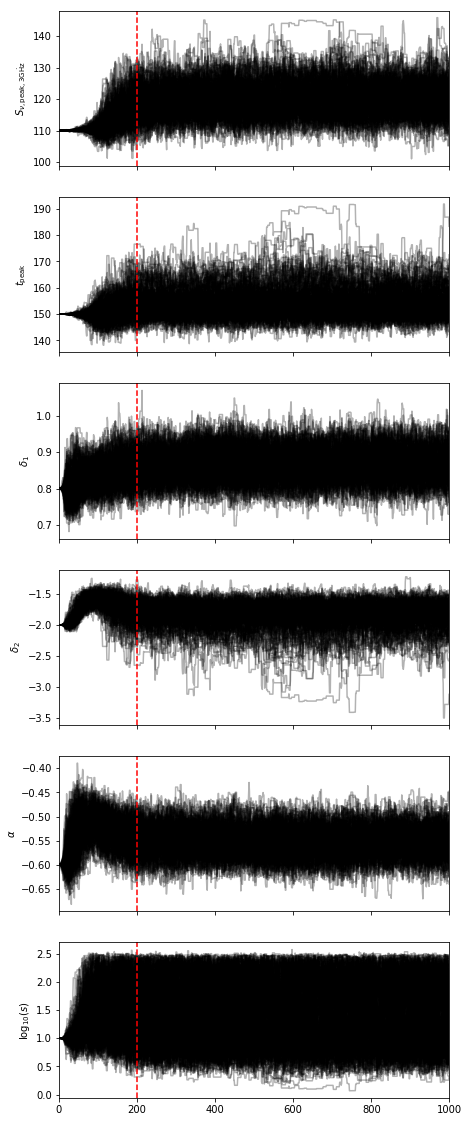

In [27]:
def make_chain_plot(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 20)
    
    param_names = ['$S_{{\\nu,\\rm peak}, 3\.{\\rm GHz}}$', '$t_{{\\rm peak}}$','$\\delta_1$','$\\delta_2$', '$\\alpha$', '$\\log_{10}(s)$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        #plot the chain for the given parameter
        ax.plot(chain[:,:,i].T,linestyle='-',color='k',alpha=0.3)        
        
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        
        ax.axvline(chain_cut,c='r',linestyle='--')

chain_cut = 200

make_chain_plot(chain, chain_cut)

Now that we know that our algorithm is converging, and we know how long the burn-in takes we can begin to estimate parameters. The function below will make a **corner** plot from the good part of your chain (using the `corner` package).

In [28]:
good_chain = chain[:, chain_cut:, :]

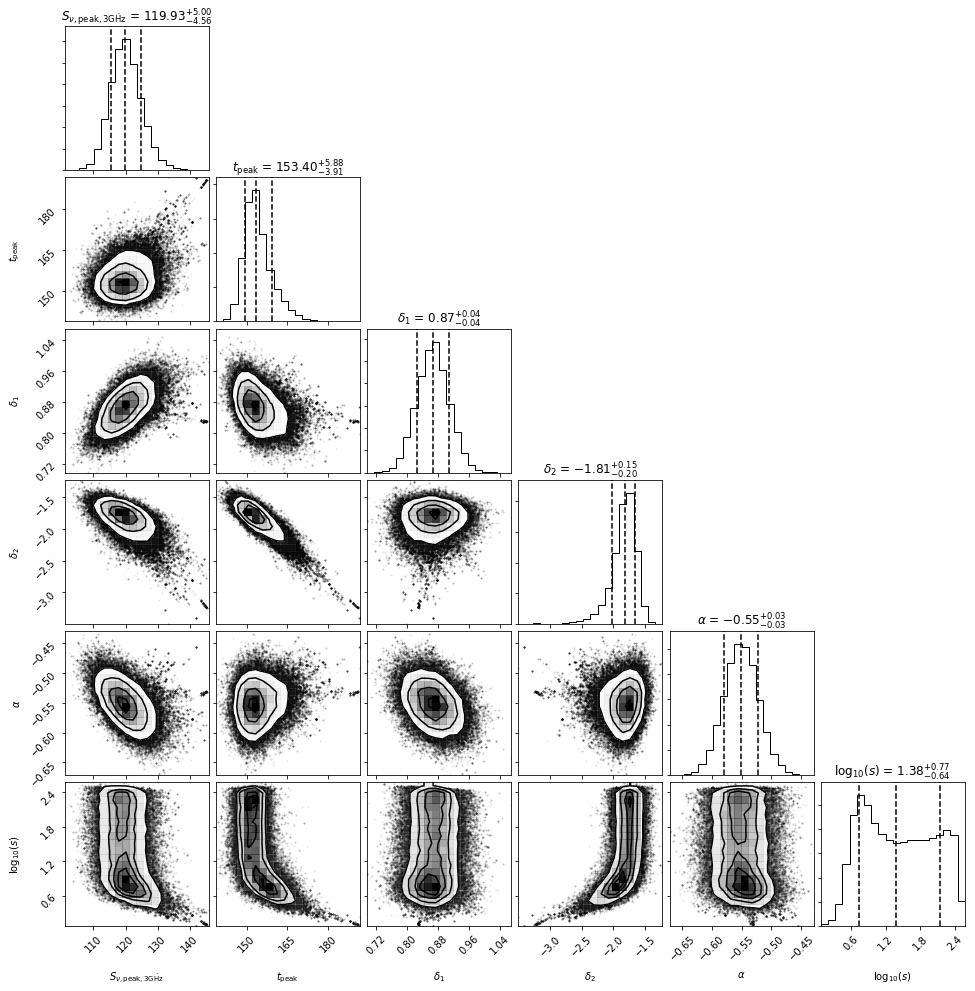

In [29]:
def make_corner_plot(good_chain, savefile='corner.png'):
    param_names = ['$S_{{\\nu,\\rm peak}, 3\.{\\rm GHz}}$', '$t_{{\\rm peak}}$','$\\delta_1$','$\\delta_2$', '$\\alpha$', '$\\log_{10}(s)$']
    ndim = good_chain.shape[2]
    
    fig = corner.corner(good_chain.reshape((-1, ndim)), labels=param_names, quantiles=[0.16, 0.5, 0.84], show_titles=True)
    plt.savefig(savefile)

make_corner_plot(good_chain)

The function below will then extract the median and uncertainty (1 standard deviation) from the chain.

In [31]:
def get_best_params(chain):
    ndim = chain.shape[2]
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    
    param_names = ['S_peak', 't_peak', 'delta_1', 'delta_2', 'alpha', 'log_s']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
    
    
best_params = get_best_params(good_chain)

Now write a function, `calc_chi2()`, that will calculate the $\chi^2$ for the fit. We will use this later to compare different lightcurve models

In [32]:
def calc_chi2(best_params, param_names, model, data, nu0=3.0):
    args = []
    for param in param_names:
        val = best_params[param][0]
        args.append(val)

    best_fit = model(data['delta_t'], nu0, *args)
    
    chi2 = np.sum((best_fit-data['scaled_flux'])**2/data['scaled_rms']**2)
    
    return chi2

param_names = ['S_peak', 't_peak', 'delta_1', 'delta_2', 'alpha', 'log_s']

chi2_best = calc_chi2(best_params, param_names, smooth_broken_power_law, tdata)
print(chi2_best)

74.2462369672762


We will now plot our best fit on top of the observational data.

Fill in the function `plot_model()` that takes in a function that calculates the model fit (in this case, our `smooth_broken_power_law` function), the best parameters, an array of values to plot the model for and a matplotlib axis to plot it on.

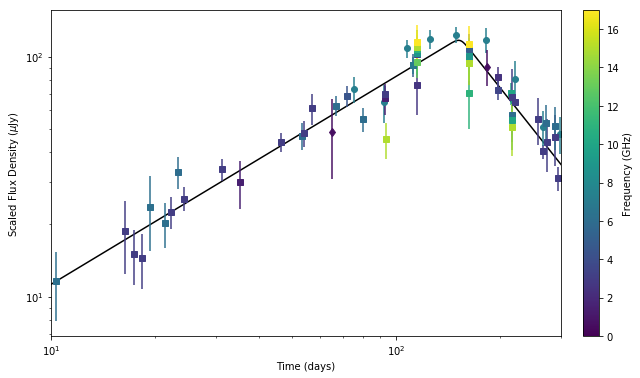

In [33]:
def plot_model(model, params, tvals, ax):
    best_fit = model(tvals, 3.0, *params)
    
    ax.plot(tvals,best_fit,marker='',linestyle='-',c='k',linewidth=1.5,zorder=0)
    
    return

args = []
for param in param_names:
    val = best_params[param][0]
    args.append(val)
    
plotting_data = scale_data(tdata, best_params['alpha'][0], np.max(best_params['alpha'][1:]))    
    
make_plot(plotting_data, scaled=True, model=smooth_broken_power_law, params=args)

The model we have fit is motivated by the qualitative shape of the lightcurve. However, there are many physical models that can be calculated, for example using hydrodynamic simulations.

The file `jet_cocoon_contribution.txt` contains a two-component lightcurve consisting of the contributions from the jet and cocoon. You can read more about these in some of our papers listed at the end of this exercise.

Now write a function to plot the best fitting model for the 3 GHz data by modifying some of the code used in previous parts of this exercise. This function will be called when you pass `plot_models=True` to your `make_plot()` function.

In [34]:
def plot_physical_models(ax, fname='jet_cocoon_contribution.txt'):
    
    data = ascii.read(fname)
    
    ax.plot(data['t'], data['cocoon']+data['jet'], label='Narrow Jet + Cocoon', c='r', linestyle='--')
    
    return ax

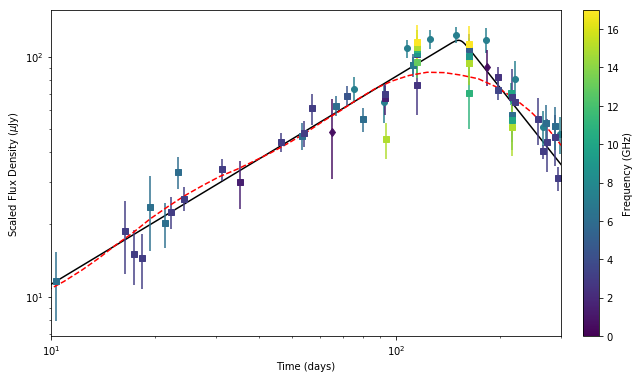

In [37]:
make_plot(plotting_data, scaled=True, model=smooth_broken_power_law, params=args, plot_models=True)

So we have now determined the final temporal/spectral behavior of the radio data.  What does this tell us?  

The fact that the spectral index stayed basically constant over time and that it was the same spectrum from radio to X-ray wavelengths (across ~9 order of magnitude in frequency) tells us that the emission is _optically-thin synchrotron emission_ [Sari et al. (1998)](https://ui.adsabs.harvard.edu/abs/1998ApJ...497L..17S/abstract), which we can use to make other inferences.  We also know that with synchrotron emission you can get a change in the spectrum at high frequencies if the highest-energy electrons have cooled: we see no evidence for a cooling break.  

The temporal behavior can be used to constrain the geometry of the emission.  This is what we (and others) did in a series of papers:
1. [Hallinan et al. (2017)](http://adsabs.harvard.edu/abs/2017Sci...358.1579H)
2. [Alexander et al. (2017)](http://adsabs.harvard.edu/abs/2017ApJ...848L..21A)
3. [Mooley et al. (2018a)](http://adsabs.harvard.edu/abs/2018Natur.554..207M)
4. [Margutti et al. (2018)](http://adsabs.harvard.edu/abs/2018ApJ...856L..18M)
5. [Dobie et al. (2018)](http://adsabs.harvard.edu/abs/2018ApJ...858L..15D)
6. [Resmi et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180302768R)
7. [Alexander et al. (2018)](http://adsabs.harvard.edu/abs/2018ApJ...863L..18A)

The latest constraints come from [Mooley et al. (2018b)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868L..11M/abstract), which argues that $\alpha$ relates to the intrinsic distribution of relativistic electrons as:
$$\alpha = -\frac{p-1}{2}$$
where the electrons have a power-law distribution of energies with index $p$.  Moreover, we can relate the same $p$ to the temporal index in the decay phase in a way that depends on the geomety:
1. If the emission is dominated by a jet (collimated, relativistic) we expect $\delta_2=-p$ in the decay phase
2. If it is more spherical it should be:
$$\delta_2 = -3\frac{p-1}{4}$$
(Sari et al. 1998 again).

Questions:
1. What do you get for $p$ based on your value of $\alpha$?
2. Which scenario, jet or sphere, do you find best fits in the decay phase?



# Bonus Exercises

When we published the first paper demonstrating evidence of a turnover we only had observations up to 200 days post-merger. We will now determine evidence for a turnover using that subset of data.

Create a new table called tdata_200 with the data up to 200 days post-merger and plot the data using your make_plot() function. Using the code from above perform a fit to this subset of the data, calculating the lightcurve parameters and $\chi^2$ of the fit.

In [39]:
tdata_200 = data[data['delta_t'] < 200]

sampler = sampler = run_mcmc(tdata_200)

good_chain = sampler.chain[:, 200:, :]

best_params = get_best_params(good_chain)

chi2_200 = calc_chi2(best_params, param_names, smooth_broken_power_law, tdata_200)

C:\Users\Dougal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
C:\Users\Dougal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


Computation time: 104.632825 s


But how do we know that the lightcurve has definitely turned over?

We can perform a similar process as above to fit a standard power law to our data and then use an **[F-test](https://en.wikipedia.org/wiki/F-test#Regression_problems)** to determine which model (turnover or no turnover) provides the best fit. We have provided a `power_law()` function that calculates the a power-law fit to the data. Now write a series of functions to perform an MCMC fit using a standard power law; `lnprior_noturnover()`, `lnlike_noturnover()`, `lnprob_noturnover()`, `get_starting_pos_noturnover()`, `run_mcmc_noturnover()`.

In [40]:
def power_law(t, nu, F0, delta_1, alpha, nu0=3.0):
    return (nu/nu0)**alpha * F0 * t**delta_1

def lnprior_noturnover(theta):
    F0, delta_1, alpha = theta

    if delta_1 > 0.0:
        return 0.0
    
    else:
        return -np.inf
    
def lnlike_noturnover(theta, t, nu, S, S_err):
    F0, delta_1, alpha = theta

    model = power_law(t, nu, F0, delta_1, alpha)
    inv_sigma2 = 1.0/S_err**2

    return -0.5*(np.sum((S-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob_noturnover(theta, t, nu, S, S_err):
    lp = lnprior_noturnover(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike_noturnover(theta, t, nu, S, S_err)

def get_starting_pos_noturnover(nwalkers, ndim=6):
    F0 = 10
    delta_1 = 0.8
    alpha = -0.6
    
    pos = [np.asarray([F0, delta_1, alpha]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

def run_mcmc_noturnover(data, niters=1000, nthreads=1, nwalkers=200, ndim=3):
    t = data['delta_t']
    nu = data['frequency']
    S = data['flux']
    S_err = data['rms']
    
    pos = get_starting_pos_noturnover(nwalkers, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_noturnover, args=(t, nu, S, S_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler

Now run the sampler for the standard power law fit and write a function to plot the chains and calculate the length of the burn-in.

In [41]:
sampler_noturnover = run_mcmc_noturnover(tdata_200)

Computation time: 80.365892 s


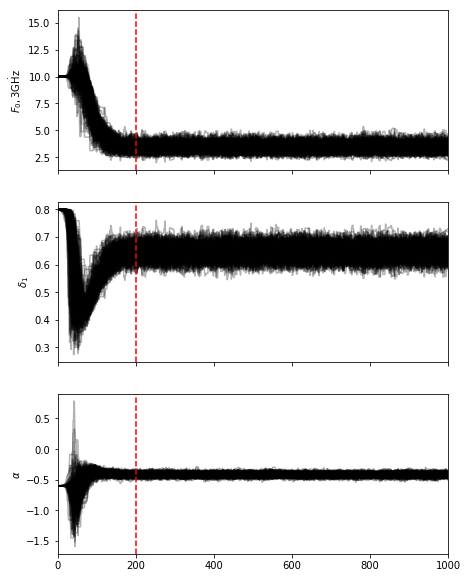

In [42]:
def make_chain_plot_noturnover(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 10)
    
    param_names = ['$F_{0}, 3\.{\\rm GHz}}$','$\\delta_1$', '$\\alpha$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        ax.plot(chain[:,:,i].T,linestyle='-',color='k',alpha=0.3)
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        ax.axvline(chain_cut,c='r',linestyle='--')

chain_noturnover = sampler_noturnover.chain
chain_cut_nt = 200

make_chain_plot_noturnover(chain_noturnover, chain_cut)

Make a corner plot for the standard power law fit

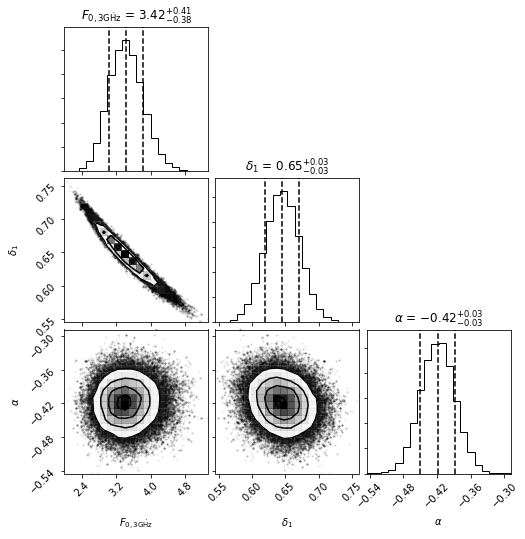

In [43]:
def make_corner_plot_noturnover(good_chain, savefile='corner.png'):
    param_names = ['$F_{0, 3\.{\\rm GHz}}$', '$\\delta_1$', '$\\alpha$']
    ndim = good_chain.shape[2]
    
    fig = corner.corner(good_chain.reshape((-1, ndim)), quantiles=[0.16, 0.5, 0.84], labels=param_names, show_titles=True)
    plt.savefig(savefile)

good_chain_nt = chain_noturnover[:, chain_cut_nt:, :]

make_corner_plot_noturnover(good_chain_nt)

How do the values of $\delta_1$ and $\alpha$ compare to the previous fit. How does the calculated radio spectral index compare to the spectral index determined from fitting data all the way from the radio to X-rays ($\alpha=-0.585\pm 0.005$; Margutti et al. 2018, ApJ, 856, L18)?

Now write a function to get the best parameters for the standard power law fit.

In [44]:
def get_best_params_noturnover(chain):
    ndim = chain.shape[2]
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    
    param_names = ['F0', 'delta_1', 'alpha']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
    
    
best_params_nt = get_best_params_noturnover(good_chain_nt)

Now that we have the best parameters for the standard power law fit we can plot it over our data. Don't forget to scale the data based on the calculated best-fit spectral index!

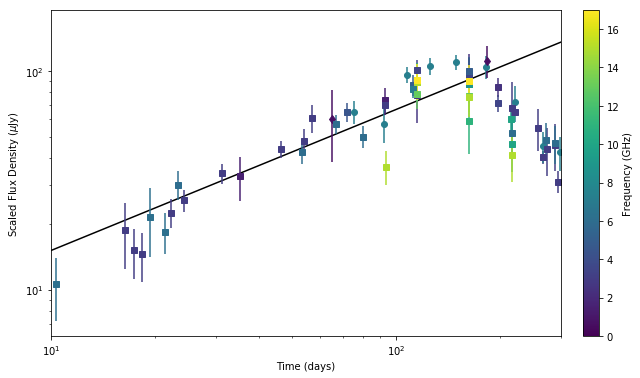

In [45]:
param_names_nt = ['F0', 'delta_1', 'alpha']
args_nt = []
for param in param_names_nt:
    val = best_params_nt[param][0]
    args_nt.append(val)
        


plotting_data_nt = scale_data(tdata, best_params_nt['alpha'][0],np.max(best_params_nt['alpha'][1:]))    
    
make_plot(plotting_data_nt,scaled=True,model=power_law,params=args_nt)

Calculate the $\chi^2$ for the standard power law fit. We will then use this, and the previously calculated $\chi^2$ to perform an F-test and determine which model we prefer.

In [46]:
chi2_nt = calc_chi2(best_params_nt, ['F0', 'delta_1', 'alpha'], power_law, tdata)
print(chi2_nt)

2960.225012441642


An [F-test](https://en.wikipedia.org/wiki/F-test) is a generalised test that can be used to compare statistical models. In particular, it is useful when comparing two models where one is a restricted form of the other. Write a function calculate_ftest that calculates the F statistic for our two fits and then calculates the corresponding p-value. Hint: We have already imported the [scipy.stats F-distribution model](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html), and we can access the cumulative distribution function using f.cdf().

In [47]:
def calculate_ftest(chi2_t, p_t, chi2_nt, p_nt, n):
    F = ((chi2_nt-chi2_t)/chi2_t) * (n-p_t)/(p_t-p_nt)
    
    pval = f.cdf(F, p_nt, p_t)
    
    return 1-pval

n = len(tdata)
p_t = 6
p_nt = 3

calculate_ftest(chi2_best, p_t, chi2_nt, p_nt, n)

3.882934729304566e-08

Which model is preferred? With what confidence can we say that we prefer one model over the other?